# Radial profiles for tropical cyclones

This notebook demonstrates the range of possible radial profiles for tropical cyclones available in TCRM. 

The radial profile is a parameterisation of the change in wind speed as a function of the radial distance from the eye of the cyclone. 

The notebook allows users to interact with the paramters that control the form of the radial profile, to gain an understanding of the influence the choice of this component may have on resulting hazard assessments.

## Background

TC models have used radial profiles in an effort to find a convenient way to represent the *gradient-level vortex* of a TC, given a limited number of parameters. 

The most commonly referenced profile is Holland's ([1980](http://journals.ametsoc.org/doi/abs/10.1175/1520-0493%281980%29108%3C1212%3AAAMOTW%3E2.0.CO%3B2)) profile, which defines the wind speed as a two-parameter formulation and is an analytic model, derived from the gradient wind equations and an assumption about the form of pressure profiles. The parameter that controls the "peakedness" of the profile $\beta$ can be determined empirically from observations.

A number of subsequent researchers meade efforts to refine the Holland model by fitting variates to observations to refine the definition of the $\beta$ parameter. Powell et al. ([2004](https://doi.org/10.1175/MWR2831.1)) and Willoughby and Rahn are two such examples. The profile of Schloemer was arguably ahead of it's time, with essentially the same functional form, but with $\beta = 1$. 

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import wind.windmodels as windmodels

from ipywidgets import interact, fixed, FloatSlider, Dropdown
import ipywidgets as widgets

import seaborn as sns
sns.set(style="ticks")
sns.set_palette("hls", 8)

In [2]:
class WindProfileFigure(Figure):

    def __init__(self, lat, lon, eP, cP, rMax, beta, beta1=1.5, beta2=1.4):
        self.R = np.array(range(1, 201), 'f')
        self.lat = lat
        self.lon = lon
        self.rMax = rMax
        self.eP = eP
        self.cP = cP
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2

    def plot(self, profileType=None):
        profiles = []

        if profileType:
            profiles.append(profileType)
        else:
            for p in windmodels.PROFILES:
                profiles.append(p)
        fig, ax = plt.subplots(1, 1)
        ax.hold(True)
        legend = []

        for name in profiles:
            try:
                cls = windmodels.profile(name)
                params = windmodels.profileParams(name)
                values = [getattr(self, p) for p in params if hasattr(self, p)]
                profile = cls(self.lat, self.lon, self.eP, self.cP,
                              self.rMax, *values)
                V = profile.velocity(self.R)
                ax.plot(self.R, abs(V), linewidth=2)
                legend.append(name.capitalize())
            except TypeError:
                pass

        ax.grid(True)
        ax.legend(legend)
        ax.set_xlabel('Radius (km)', fontsize=14)
        ax.set_ylabel('Wind speed (m/s)', fontsize=14)
        ax.set_title((r'$P_c = %d\hspace{0.5}hPa,\hspace{1} P_e' +
                      r'= %d \hspace{0.5} hPa,\hspace{1} R_{max}' +
                      r'= %d \hspace{0.5}km$') %
                      (self.cP/100., self.eP/100., self.rMax))
        plt.show()


In [3]:
def plotProfile(lat, lon, rMax, eP, cP, beta, profile):
    fig = WindProfileFigure(lat, lon, eP, cP, rMax, beta)
    fig.plot(profileType=profile)
    
profileList = [p for p in windmodels.PROFILES]
profileList.insert(0, "")
p = Dropdown(options=profileList, value="", description="Profile")

In [4]:
interact(plotProfile, 
         lat=FloatSlider(value=-15., min=-30, max=0, step=0.1, description="Latitude"), 
         lon=fixed(120),
         rMax=FloatSlider(value=20, min=10, max=100, step=1, description="Radius to max winds (km)"),
         eP=(99500, 100000, 100),
         cP=(90000, 99000, 100),
         beta=(1.2, 2.5, 0.05),
         profile=p)

<function __main__.plotProfile>

The differences arise for a number of reasons. Firstly, the absolute maximum vaires, because a number of the individual profiles stipulate a pressure wind relation. For the profiles here, these are the Willoughby, Holland and Atkinson and Holliday profiles. 

Willoughby: $V_{max} = 0.6252 \times \sqrt{\Delta p}$

Holland: $V_{max} = \sqrt{\frac{\beta \Delta p}{\rho e}}$

Atkinson & Holliday: $V_{max} = 3.04 (1010.0 - p_c)^{0.644}$

Note how the Willoughby wind-pressure relationship is only a function of the pressure difference ($\Delta p$), whereas the Holland Profile is a function of $\Delta p$ *and* the $\beta$ parameter. For small $\Delta p$ (weak storms) the difference between these two models is small, but for intense storms (large $\Delta p$), there is a large difference.


Take a look at the formulation for the $\beta$ parameter for these two profiles. Note below that we've plotted multiple lines for the Willoughby formulation, as it is also a function of maximum wind speed ($V_{max}$). The latitude for these is set at 20$^{\circ}$S.

<IPython.core.display.Javascript object>


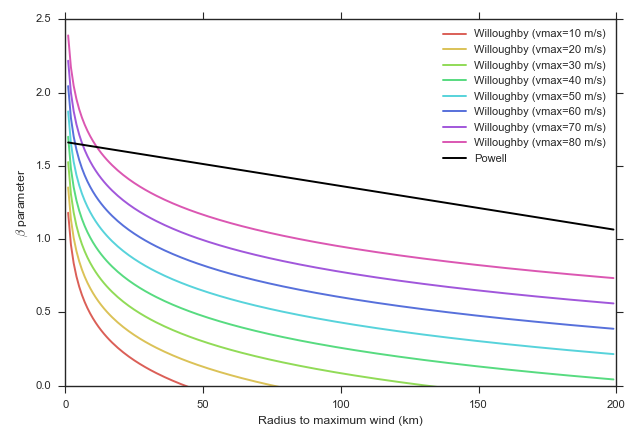

In [6]:
def plotbeta():
    fig, ax = plt.subplots(1, 1)
    lat = -20.
    rMax = np.arange(1, 200, 1)
    powellbeta = 1.881093 - 0.010917 * np.abs(lat) - 0.005567 * rMax/1.854
    for v in range(10, 90, 10):
        willbeta = (1.0036 + 0.0173 * v - 0.313 * np.log(rMax) + 0.0087 *np.pi*(np.abs(lat))/180.)
        ax.plot(rMax, willbeta, label="Willoughby (vmax={0:d} m/s)".format(v))
    
    ax.plot(rMax, powellbeta, label='Powell', c='k')
    ax.set_ylim((.0, 2.5))
    ax.legend()
    ax.set_xlabel("Radius to maximum wind (km)")
    ax.set_ylabel(r"$\beta$ parameter")
    fig.tight_layout()
    plt.show()
    
plotbeta()

What are the implications of the shape of these curves? What would you expect the radial profile for a strong TC to look like, if you chose the Willoughby & Rahn profile? What about the Powell *et al.* profile?

### Questions:

What happens to the double Holland profile for a very weak storm?

Find the range of values of maximum wind for conditions similar to TC Winston at landfall (central pressure = xxx, radius to maximum wind = yyy, latitude = zzz, ). Compare that to the estimated landfall intesity reported by the Fiji Meteorological Service. What are some reasons for this difference?